# Thesis Python Script - Richard-Constandine Allan

The following text is a Python script that I have written as a part of my thesis. This script is designed to perform specific tasks related to my research, including analysing natural gas determinants and forecasting natural gas prices.

# Part 1 - Import Libraries

In [3]:
import pandas as pd 
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from scipy.stats import kurtosis
import scipy.stats as stats
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVR 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Part 2 - Import Data

In [4]:
Cap = pd.read_csv("........../NG_Capacity.csv")
Temp = pd.read_csv("........../Temp_W_Europe.csv")
TTF = pd.read_csv("........../Data_Thesis/TTF_Price.csv")
Brent = pd.read_csv("........../Brent.csv")
Coal = pd.read_csv("........../Coal.csv")

In [5]:
TTF = TTF.rename(columns={'Close Price': 'TTF_Price'})

# Part 3 - Converting Data

Brent Oil

In [6]:
Brent.head()

,Date,Brent_Price
0,1/2/2014,81.38
1,1/3/2014,80.35
2,1/6/2014,80.45
3,1/7/2014,80.68
4,1/8/2014,80.99


In [7]:
Brent.count()

Date           1631
Brent_Price    1631
dtype: int64

In [8]:
Brent.describe()

,Brent_Price
count,1631.000000
mean,53.295604
std,14.226052
min,8.000000
25%,43.845000
50%,52.980000
75%,60.655000
max,86.850000


Coal

In [9]:
Coal.head()

,Date,Coal_Price
0,1/2/2014,60.88
1,1/3/2014,59.94
2,1/6/2014,60.13
3,1/7/2014,60.01
4,1/8/2014,61.75


In [10]:
Coal.count()

Date           1631
 Coal_Price    1631
dtype: int64

In [11]:
Coal.describe()

,Coal_Price
count,1631.000000
mean,60.497039
std,13.554746
min,33.720000
25%,50.740000
50%,55.880000
75%,72.900000
max,86.970000


Capacity

In [12]:
Cap.head()

,Date,Capacity
0,1/1/2014,69%
1,1/2/2014,69%
2,1/3/2014,69%
3,1/4/2014,69%
4,1/5/2014,69%


In [13]:
Cap.count()

Date        2312
Capacity    2312
dtype: int64

In [14]:
Cap.describe()

,Date,Capacity
count,2312,2312
unique,2312,81
top,1/1/2014,83%
freq,1,63


TTF

In [15]:
TTF.head()

,Date,TTF_Price
0,01/01/14,28.225
1,02/01/14,26.300
2,03/01/14,26.038
3,04/01/14,26.750
4,05/01/14,25.975


In [16]:
TTF.count()

Date         2312
TTF_Price    2298
dtype: int64

In [17]:
TTF.describe()

,TTF_Price
count,2298.000000
mean,17.597661
std,4.929174
min,5.675000
25%,14.250000
50%,17.827500
75%,21.025000
max,72.375000


Temperature

In [18]:
Temp.head()

,Date,Temperature
0,1/1/2014,7.6
1,1/2/2014,8.8
2,1/3/2014,9.1
3,1/4/2014,8.1
4,1/5/2014,5.8


In [19]:
Temp.describe()

,Temperature
count,2312.000000
mean,10.334645
std,30.395179
min,-999.900000
25%,6.300000
50%,11.000000
75%,16.025000
max,31.200000


In [20]:
Temp.count()

Date           2312
Temperature    2312
dtype: int64

In [21]:
#convert Capacity from % to decimals
Cap['decimal'] = Cap['Capacity'].apply(lambda x: float(x.strip('%')) / 100)
Cap = Cap.drop('Capacity',axis=1)
Cap = Cap.rename(columns={'decimal': 'Capacity'})

In [22]:
Coal = Coal.rename(columns={' Coal_Price': 'Coal_Price'})
#convert dfs to time series by setting date as an index
TTFts = TTF.set_index("Date")
Capts = Cap.set_index("Date")
Tempts = Temp.set_index("Date")
Brentts = Brent.set_index("Date")
Coalts = Coal.set_index("Date")

In [23]:
#convert all indexes to datetime objects(all indexes need to be in the same format in order to merge)

TTFts.index = pd.to_datetime(TTFts.index,dayfirst=True)
Tempts.index = pd.to_datetime(Tempts.index)
Capts.index = pd.to_datetime(Capts.index)
Brentts.index = pd.to_datetime(Brentts.index)
Coalts.index = pd.to_datetime(Coalts.index)

In [24]:
# Resample and fill the missing values of Brent
Brentts = Brentts.resample('D').mean()
Brentts = Brentts.ffill()

In [25]:
# Resample and fill the missing values of Coal
Coalts = Coalts.resample('D').mean()
Coalts = Coalts.ffill()

In [26]:
#replace -999 temperature data entry error with the average
avg_temperature=Tempts['Temperature'].mean()
for i in range(len(Tempts)):
               if Tempts.iloc[i,0]<-900:
                   Tempts.iloc[i,0]=avg_temperature

# Part 4 - Merge Dataframes

In [27]:
df = pd.merge(TTFts, Tempts, left_index=True,right_index=True).merge(Capts, left_index=True, right_index=True).merge(Coalts, left_index=True,right_index=True).merge(Brentts, left_index=True,right_index=True)
#drop NAs
df = df.dropna()

In [28]:
df.head()

,TTF_Price,Temperature,Capacity,Coal_Price,Brent_Price
Date,,,,,
2014-01-02,26.300,8.8,0.69,60.88,81.38
2014-01-03,26.038,9.1,0.69,59.94,80.35
2014-01-04,26.750,8.1,0.69,59.94,80.35
2014-01-05,25.975,5.8,0.69,59.94,80.35
2014-01-06,26.550,11.4,0.69,60.13,80.45


In [29]:
df.tail()

,TTF_Price,Temperature,Capacity,Coal_Price,Brent_Price
Date,,,,,
2020-04-25,5.808,10.5,0.61,36.04,30.50
2020-04-26,5.800,10.6,0.61,36.04,30.50
2020-04-27,5.925,13.8,0.62,34.29,29.64
2020-04-28,6.025,11.8,0.62,33.72,29.77
2020-04-29,5.875,12.7,0.62,34.20,28.70


In [30]:
df.count()

TTF_Price      2297
Temperature    2297
Capacity       2297
Coal_Price     2297
Brent_Price    2297
dtype: int64

In [31]:
df.tail()

,TTF_Price,Temperature,Capacity,Coal_Price,Brent_Price
Date,,,,,
2020-04-25,5.808,10.5,0.61,36.04,30.50
2020-04-26,5.800,10.6,0.61,36.04,30.50
2020-04-27,5.925,13.8,0.62,34.29,29.64
2020-04-28,6.025,11.8,0.62,33.72,29.77
2020-04-29,5.875,12.7,0.62,34.20,28.70


# Part 5 - Creating Plots

TTF Price Plot

Text(0, 0.5, 'TTF Price')

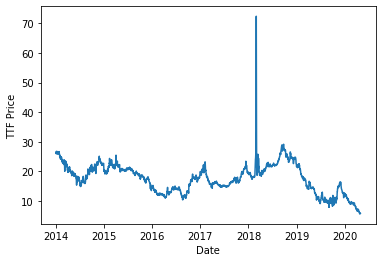

In [32]:
plt.plot(df.index, df.TTF_Price)
plt.xlabel('Date')
plt.ylabel('TTF Price')

Western Europe Temperature Plot

Text(0, 0.5, 'Temperature')

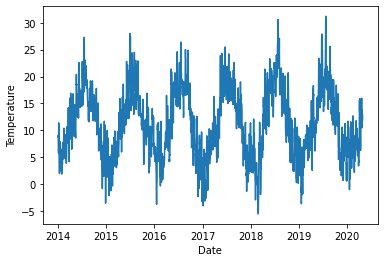

In [33]:
plt.plot(df.index, df.Temperature)
plt.xlabel('Date')
plt.ylabel('Temperature')

Natural Gas Storage Capacity Plot

Text(0, 0.5, 'Capacity')

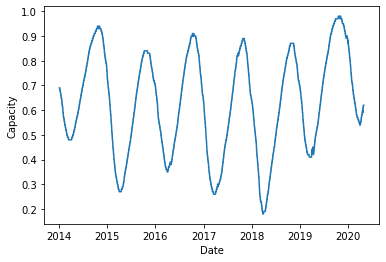

In [34]:
plt.plot(df.index, df.Capacity)
plt.xlabel('Date')
plt.ylabel('Capacity')

Coal Price Plot

Text(0, 0.5, 'Coal Price')

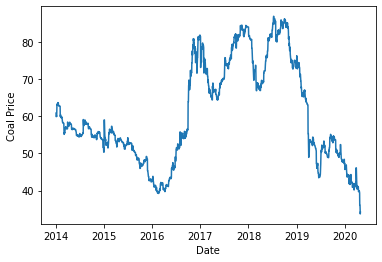

In [35]:
plt.plot(df.index, df. Coal_Price)
plt.xlabel('Date')
plt.ylabel('Coal Price')

Brent Oil Price Plot

Text(0, 0.5, 'Brent Price')

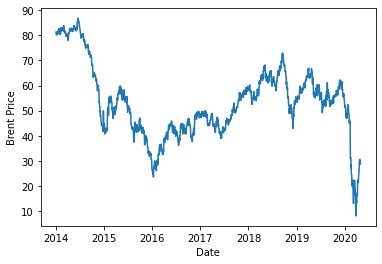

In [36]:
plt.plot(df.index, df.Brent_Price)
plt.xlabel('Date')
plt.ylabel('Brent Price')

# Part 6 - Descriptive Statistics

Basic Stats

In [37]:
stats = df.describe()
print(stats)

         TTF_Price  Temperature     Capacity   Coal_Price  Brent_Price
count  2297.000000  2297.000000  2297.000000  2297.000000  2297.000000
mean     17.593034    11.203818     0.626369    60.527344    53.221824
std       4.925254     6.330138     0.207828    13.556858    14.219853
min       5.675000    -5.500000     0.180000    33.720000     8.000000
25%      14.250000     6.200000     0.470000    50.740000    43.950000
50%      17.825000    11.000000     0.630000    55.950000    52.880000
75%      21.025000    16.100000     0.820000    72.940000    60.310000
max      72.375000    31.200000     0.980000    86.970000    86.850000


Median

In [38]:
median = df.median()
print("Median:", median)

Median: TTF_Price      17.825
Temperature    11.000
Capacity        0.630
Coal_Price     55.950
Brent_Price    52.880
dtype: float64


Variance

In [39]:
# Calculate the variance
variance = np.var(df)

# Print the result
print("Variance:", variance)

Variance: TTF_Price       24.247564
Temperature     40.053206
Capacity         0.043173
Coal_Price     183.708373
Brent_Price    202.116200
dtype: float64


Kurtosis

In [40]:
kurt = kurtosis(df)
print("Kurtosis:", kurt)
# a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution

Kurtosis: [ 7.20506869 -0.6089243  -1.04457683 -1.1092589   0.22951845]


Skewness

In [41]:
print("Skewness:", df.skew())
# a measurement of the distortion of symmetrical distribution or asymmetry in a data set.

Skewness: TTF_Price      0.697489
Temperature    0.094835
Capacity      -0.189532
Coal_Price     0.343986
Brent_Price    0.168428
dtype: float64


Correlation Matrix

In [42]:
correlation_matrix = df.corr()
print(correlation_matrix)

             TTF_Price  Temperature  Capacity  Coal_Price  Brent_Price
TTF_Price     1.000000    -0.182388 -0.119519    0.542994     0.476108
Temperature  -0.182388     1.000000  0.102892   -0.013909     0.142245
Capacity     -0.119519     0.102892  1.000000   -0.007307     0.021345
Coal_Price    0.542994    -0.013909 -0.007307    1.000000     0.307382
Brent_Price   0.476108     0.142245  0.021345    0.307382     1.000000


Correlation Heatmap

<AxesSubplot:>

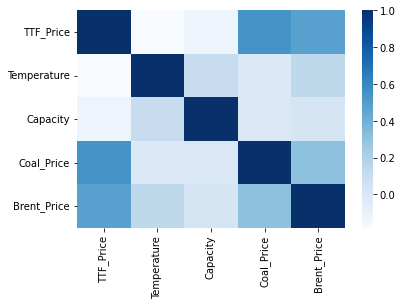

In [43]:
sns.heatmap(df.corr(), cmap ='Blues')

Autocorrelation

In [44]:
acf0 = df['TTF_Price'].autocorr(lag=0)
acf1 = df['TTF_Price'].autocorr(lag=1)
acf2 = df['TTF_Price'].autocorr(lag=2)
acf3 = df['TTF_Price'].autocorr(lag=3)
acf4 = df['TTF_Price'].autocorr(lag=4)
acf5 = df['TTF_Price'].autocorr(lag=5)
acf6 = df['TTF_Price'].autocorr(lag=6)
acf7 = df['TTF_Price'].autocorr(lag=7)
acf8 = df['TTF_Price'].autocorr(lag=8)
acf9 = df['TTF_Price'].autocorr(lag=9)
acf10 = df['TTF_Price'].autocorr(lag=10)
acf11 = df['TTF_Price'].autocorr(lag=11)
acf12 = df['TTF_Price'].autocorr(lag=12)
acf13 = df['TTF_Price'].autocorr(lag=13)
acf14 = df['TTF_Price'].autocorr(lag=14)
acf15 = df['TTF_Price'].autocorr(lag=15)
acf16 = df['TTF_Price'].autocorr(lag=16)
acf17 = df['TTF_Price'].autocorr(lag=17)
acf18 = df['TTF_Price'].autocorr(lag=18)
acf19 = df['TTF_Price'].autocorr(lag=19)
acf20 = df['TTF_Price'].autocorr(lag=20)
# print the autocorrelation value
print('Autocorrelation:', acf0, acf1, acf2, acf3, acf4, acf5, acf6, acf7, acf8, acf9, acf10, acf11, acf12, acf13, acf14, acf15, acf16, acf17, acf18, acf19, acf20)

Autocorrelation: 1.0 0.9796374965683383 0.9516375287369354 0.9295237947418986 0.9154863659543945 0.9062616384823889 0.8991329667550165 0.8929190467428864 0.8882678502020176 0.8842898075737974 0.8810879782639693 0.8807104582998724 0.8809383493553252 0.8781981576480716 0.8743303058143558 0.8701012142154967 0.8668102889808822 0.8651077432554685 0.8613976792242146 0.8564384743189795 0.852120468890634


Autocorrelation Plot

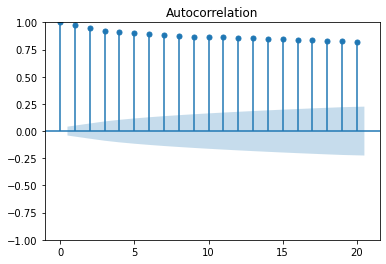

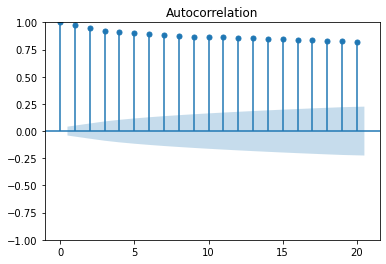

In [45]:
plot_acf(df['TTF_Price'], lags=20)

Partial Autocorrelation

In [46]:
# calculate partial autocorrelation of a specific column in the dataframe
pacf = sm.tsa.stattools.pacf(df['TTF_Price'], nlags=20, method='ols')

# print the partial autocorrelation values
print('Partial Autocorrelation:', pacf)

Partial Autocorrelation: [ 1.          0.98017979 -0.1976493   0.17523922  0.1327116   0.07690726
  0.0675203   0.05997655  0.07869122  0.04210064  0.06034579  0.11082733
  0.03337429 -0.02010845  0.05088113  0.01345758  0.03779743  0.04755227
 -0.04298623  0.01610245  0.02542429]


Partial Autocorrelation Plot

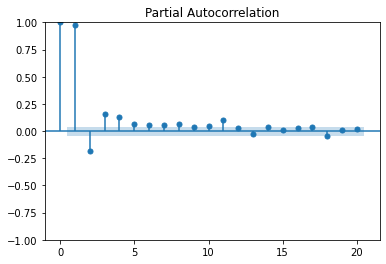

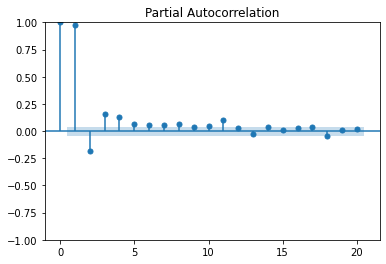

In [47]:
plot_pacf(df['TTF_Price'], lags=20)

# Part 7 - Train-Test Split

In [48]:
df = df.reset_index()

In [49]:
#split dataset into dependent variable and regressors
Dependent = df.loc[:,['Date','TTF_Price']]
Regressors = df.loc[:,['Date','Temperature','Capacity','Brent_Price','Coal_Price']]

In [50]:
#80%
Dependent_train = Dependent.head(1838)
Regressors_train = Regressors.head(1838)

#20%
Dependent_test = Dependent.tail(459)
Regressors_test = Regressors.tail(459)

In [51]:
Dependent_train.head()

,Date,TTF_Price
0,2014-01-02,26.300
1,2014-01-03,26.038
2,2014-01-04,26.750
3,2014-01-05,25.975
4,2014-01-06,26.550


In [52]:
Regressors_train.head()

,Date,Temperature,Capacity,Brent_Price,Coal_Price
0,2014-01-02,8.8,0.69,81.38,60.88
1,2014-01-03,9.1,0.69,80.35,59.94
2,2014-01-04,8.1,0.69,80.35,59.94
3,2014-01-05,5.8,0.69,80.35,59.94
4,2014-01-06,11.4,0.69,80.45,60.13


In [53]:
Dependent_test.head()

,Date,TTF_Price
1838,2019-01-26,20.600
1839,2019-01-27,20.775
1840,2019-01-28,20.838
1841,2019-01-29,20.838
1842,2019-01-30,20.538


In [54]:
Regressors_test.head()

,Date,Temperature,Capacity,Brent_Price,Coal_Price
1838,2019-01-26,6.9,0.56,59.32,71.24
1839,2019-01-27,5.5,0.55,59.32,71.24
1840,2019-01-28,3.2,0.55,58.83,70.57
1841,2019-01-29,1.5,0.54,59.69,71.24
1842,2019-01-30,0.5,0.53,59.77,71.33


Since all the steps of preprocessing are finished, the models can now be trained with the train set and make precictions. 

# Part 8 -  SVR

set Y and X
x = Regressors
y = Dependent

In [55]:
x = Regressors
y = Dependent

In [56]:
#set index in order to proceed to scaling
x = x.set_index('Date')
y = y.set_index('Date')

In [57]:
sc_x = StandardScaler()
x = sc_x.fit_transform(x)
sc_y = StandardScaler()
y = sc_y.fit_transform(y)

In [58]:
#split for arrays
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [59]:
#GRID SEARCH, SVR OPTIMIZER, required to run once
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10],
              'gamma': [0.001, 0.01, 0.1, 1],
              'kernel': ['linear', 'rbf']}
svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5)
grid_search.fit(x_train, y_train.ravel())
print(grid_search.best_params_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [60]:
model = SVR(kernel='rbf', C=10, gamma=1)
model.fit(x_train, y_train.ravel())

SVR(C=10, gamma=1)

In [61]:
y_pred = model.predict(x_test)

SVR Evaluation Metrics

In [62]:
#random results, run 10 times and report the average of the performance metrics
print("SVR Results")
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE: ", rmse)
mape = mean_absolute_percentage_error(y_test,y_pred)
print("MAPE: ", mape)
mae = mean_absolute_error(y_test, y_pred)
print("MAE: ", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)
#SVR with diff, try stationarity to see if better results are yielded

SVR Results

RMSE:  0.44
MAPE:  1.5594770410172776
MAE:  0.17995991426760824
R-squared: 0.8297280013755115


Applying First Differencing

In [63]:
df1 = df
df1 = df1.set_index('Date')
df1_diff = df1.diff().dropna()
df1_diff = df1_diff.reset_index()

In [64]:
y = df1_diff.loc[:,['Date','TTF_Price']]
x = df1_diff.loc[:,['Date','Temperature','Capacity','Brent_Price','Coal_Price']]

In [65]:
y = y.set_index('Date')
x = x.set_index('Date')

In [66]:
sc_x = StandardScaler()
x = sc_x.fit_transform(x)
sc_y = StandardScaler()
y = sc_y.fit_transform(y)

In [67]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [68]:
from sklearn.model_selection import GridSearchCV
param_grid2 = {'C': [0.1, 1, 10],
              'gamma': [0.001, 0.01, 0.1, 1],
              'kernel': ['linear', 'rbf']}
svr = SVR()
grid_search = GridSearchCV(svr, param_grid2, cv=5)
grid_search.fit(x_train, y_train.ravel())
print(grid_search.best_params_)

{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}


In [69]:
model = SVR(kernel='rbf', C=0.1, gamma=0.1)
model.fit(x_train, y_train.ravel())

SVR(C=0.1, gamma=0.1)

SVR First Differencing Evaluation Mertrics

In [70]:
y_pred = model.predict(x_test)
print("SVR 1st Diff Results")
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE: ", rmse)
mape = mean_absolute_percentage_error(y_test,y_pred)
print("MAPE: ", mape)
mae = mean_absolute_error(y_test, y_pred)
print("MAE: ", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

SVR 1st Diff Results

RMSE:  0.403
MAPE:  1.323477482275591
MAE:  0.2606476098386122
R-squared: 0.01441177983134767


# Part 9 - SARIMAX

In [71]:
#ADF Test
dftest = adfuller(df.TTF_Price, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.977940454959069
2. P-Value :  0.2963284040872005
3. Num Of Lags :  17
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 2279
5. Critical Values :
	 1% :  -3.4332226111473805
	 5% :  -2.86280905025955
	 10% :  -2.567445573742053


p-value = 0,29, non stationary time series, requires differencing

In [72]:
# Set the date column as the index
Dependent_train=Dependent_train.set_index("Date")
Regressors_train=Regressors_train.set_index("Date")
Dependent_test=Dependent_test.set_index("Date")
Regressors_test=Regressors_test.set_index("Date")

SARIMAX RESULTS

In [73]:
# Create the SARIMAX model with 5 regressors
#model = sm.tsa.SARIMAX(Dependent_train, exog=Regressors_train, order=(2,1,2), seasonal_order=(0,0,0,0))

model = auto_arima(Dependent_train, exogenous =Regressors_train, seasonal=True, max_order=None, suppress_warnings=True, stepwise=True)
print(model.summary())
sarimaxforecasts = model.predict(n_periods=len(Dependent_test), exogenous=Regressors_test)
#sarimaxforecasts = results.get_forecast(steps=326, exog=Regressors_test)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1838
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -2645.333
Date:                Fri, 07 Apr 2023   AIC                           5298.666
Time:                        15:25:37   BIC                           5320.729
Sample:                             0   HQIC                          5306.802
                               - 1838                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0105      0.008    130.374      0.000       0.995       1.026
ar.L2         -0.3168      0.009    -35.171      0.000      -0.334      -0.299
ma.L1         -0.8814      0.008   -117.465      0.0

SARIMAX Evaluation Metrics

In [74]:
rmse = np.sqrt(mean_squared_error(Dependent_test, sarimaxforecasts))
mape = mean_absolute_percentage_error(Dependent_test, sarimaxforecasts)
mae = mean_absolute_error(Dependent_test, sarimaxforecasts)
r2 = r2_score(Dependent_test, sarimaxforecasts)
print("SARIMAX Results")
print("\nRMSE: ", rmse)
print("MAPE: ", mape)
print("MAE: ", mae)
print("R-squared:", r2)

SARIMAX Results

RMSE:  10.256857297129665
MAPE:  0.9553343000511084
MAE:  9.727424281250252
R-squared: -9.004687822614608


# Part 10 - MLR

In [75]:
LRX_train = Regressors_train
LRY_train = Dependent_train
#LRX_train = LRX_train.reset_index(drop=True)
#LRY_train = LRY_train.reset_index(drop=True)

LRX_test = Regressors_test
LRY_test = Dependent_test
#LRX_test = LRX_test.reset_index(drop=True)
#LRY_test = LRY_test.reset_index(drop=True)

In [76]:
#X_train, X_test, y_train, y_test = train_test_split(LRX, LRY, test_size=0.2)
lr = LinearRegression().fit(LRX_train, LRY_train)

In [77]:
# Make predictions with the regressor test set
lry_pred = lr.predict(LRX_test)

MLR Evaluation Metrics

In [78]:
mape = mean_absolute_percentage_error(LRY_test, lry_pred)
rmse = np.sqrt(mean_squared_error(LRY_test, lry_pred))
mae = mean_absolute_error(LRY_test, lry_pred)
r2 = r2_score(LRY_test, lry_pred)
print("Linear Regression Results")
print("\nRMSE: ", rmse)
print("\nMAPE: ", mape)
print("MAE: ", mae)
print("R-squared:", r2)

Linear Regression Results

RMSE:  5.992219981995025

MAPE:  0.5380565395279332
MAE:  5.728864464873071
R-squared: -2.414683156333511


# Part 11 - 4th Model: RNN

In [79]:
# load the dat/aset
dfrnn = df
dfrnn = dfrnn.set_index('Date')

In [80]:
# Select target variable and regressors
target_var = 'TTF_Price'
regressors = ['Temperature', 'Capacity', 'Coal_Price', 'Brent_Price']

In [81]:
# Split data into train and test sets
train_data = df.head(1838)
test_data = df.tail(459)

In [82]:
# Scale data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data[[target_var] + regressors])
test_data_scaled = scaler.transform(test_data[[target_var] + regressors])

In [83]:
#  Define function to create samples
def create_samples(data, n_steps):
    X, Y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps, 1:])
        Y.append(data[i+n_steps, 0])
    return np.array(X), np.array(Y)

In [84]:
# Set number of time steps
n_steps = 5

In [85]:
# Create train and test samples
X_train, Y_train = create_samples(train_data_scaled, n_steps)
X_test, Y_test = create_samples(test_data_scaled, n_steps)

In [88]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps, len(regressors))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [89]:
# Fit model
model.fit(X_train, Y_train, epochs=200, verbose=0)

In [90]:
# Make predictions
y_pred = model.predict(X_test)

15/15 [==============================] - 0s 4ms/step


In [91]:
# Inverse transform predictions and actual values
y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred, test_data_scaled[-len(y_pred):, 1:]), axis=1))[:, 0]
Y_test_inv = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1,1), test_data_scaled[-len(y_pred):, 1:]), axis=1))[:, 0]

RNN Evaluation Metrics

In [92]:
rmse = np.sqrt(mean_squared_error(Y_test_inv, y_pred_inv))
mape = mean_absolute_percentage_error(Y_test_inv,y_pred_inv)
mae = mean_absolute_error(Y_test_inv,y_pred_inv)
r2 = r2_score(Y_test_inv,y_pred_inv)
print('RNN-LSTM Results')
print("\nRMSE: ", rmse)
print("\nMAPE: ", mape)
print("MAE: ", mae)
print("R-squared:", r2)

RNN-LSTM Results

RMSE:  7.896046825265158

MAPE:  0.7117652288711713
MAE:  7.5198405069541385
R-squared: -5.380401439810931


# This is the end of my data analysis notebook. The results and conclusion will be presented in my thesis. Thanks for your time